### Predicting Risky drivers for the insurance company
 - here the target is to find out whether the particular driver filed a particular case or not 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,roc_auc_score,roc_curve,classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LassoCV,ridge,ElasticNetCV,ElasticNetCV
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import sequential_feature_selector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df=pd.read_csv('seguro_train.csv')

In [3]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
df.shape

(595212, 59)

In [74]:
df['target'].value_counts(normalize=True)

0.0    0.963552
1.0    0.036448
Name: target, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [8]:
#ro get the variables which are catogorical
cat=[]
List=list(df.columns)
for i in List:
    if i[-3:]=='cat':
        cat.append(i)
cat   

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [5]:
cols=list(df.columns)
df=np.where(df==-1,np.nan,df)
df=pd.DataFrame(df,columns=cols)

- we are doing this becuase there are some values equal to the -1 in the columsn and hence we are changing sl those values to the null values si that we can impute those values later 

In [22]:
null=df.isnull().sum()
null/df.shape[0]

id                0.000000
target            0.000000
ps_ind_01         0.000000
ps_ind_02_cat     0.000363
ps_ind_03         0.000000
ps_ind_04_cat     0.000139
ps_ind_05_cat     0.009760
ps_ind_06_bin     0.000000
ps_ind_07_bin     0.000000
ps_ind_08_bin     0.000000
ps_ind_09_bin     0.000000
ps_ind_10_bin     0.000000
ps_ind_11_bin     0.000000
ps_ind_12_bin     0.000000
ps_ind_13_bin     0.000000
ps_ind_14         0.000000
ps_ind_15         0.000000
ps_ind_16_bin     0.000000
ps_ind_17_bin     0.000000
ps_ind_18_bin     0.000000
ps_reg_01         0.000000
ps_reg_02         0.000000
ps_reg_03         0.181065
ps_car_01_cat     0.000180
ps_car_02_cat     0.000008
ps_car_03_cat     0.690898
ps_car_04_cat     0.000000
ps_car_05_cat     0.447825
ps_car_06_cat     0.000000
ps_car_07_cat     0.019302
ps_car_08_cat     0.000000
ps_car_09_cat     0.000956
ps_car_10_cat     0.000000
ps_car_11_cat     0.000000
ps_car_11         0.000008
ps_car_12         0.000002
ps_car_13         0.000000
p

- we can see that the car_03 and car_05 cat columns are having the highest missing values and hence we are dropping those columns

In [6]:
df.drop(['ps_car_03_cat','ps_car_05_cat'],1,inplace=True)

In [9]:
df[cat]=df[cat].fillna(df[cat].mode().iloc[0])#we are using the iloc here because to capture tha max occurence of the value in the columnns

In [10]:
df=df.fillna(method='ffill')

In [29]:
df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359668,4.423318,0.416934,0.414948,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663108,2.699902,0.493052,1.344050,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis- Bivariate

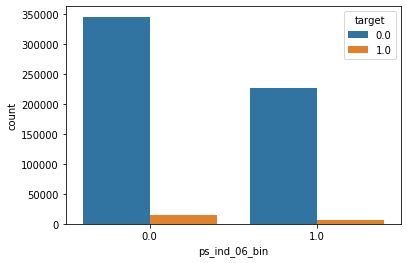

In [31]:
#ps_ind_06 (bin vs bin)
sns.countplot(x='ps_ind_06_bin',hue='target',data=df)
plt.show()

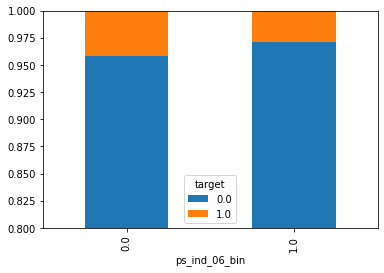

In [36]:
pd.crosstab(df['target'],df['ps_ind_06_bin'],normalize=1).T.plot(kind='bar',stacked=True)
plt.ylim(0.8,1) ## this is used to limit the y scale
plt.show()

### ps_calc_01(bin vs continous)

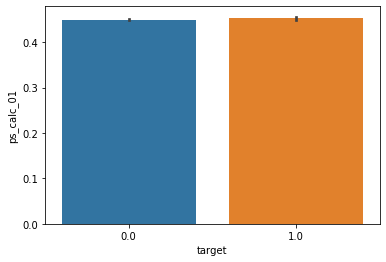

In [37]:
sns.barplot(x='target',y='ps_calc_01',data=df)
plt.show()

### ps_car_13 (bin vs continous)

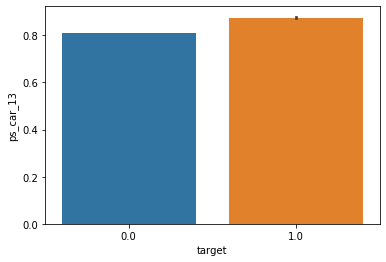

In [38]:
sns.barplot(x='target',y='ps_car_13',data=df)
plt.show()

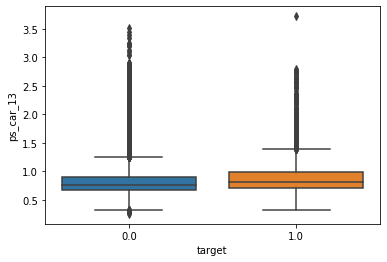

In [39]:
sns.boxplot(x='target',y='ps_car_13',data=df)
plt.show()

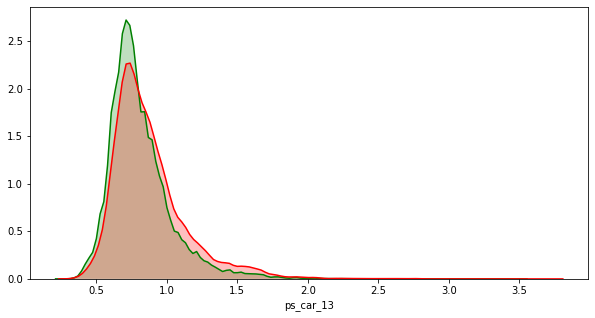

In [43]:
plt.figure(figsize=(10,5))
df0=df[df['target']==0]['ps_car_13']
df1=df[df['target']==1]['ps_car_13']
sns.distplot(df0,color='g',hist=False,kde_kws={'shade':True})
sns.distplot(df1,color='r',hist=False,kde_kws={'shade':True})
plt.show()

### ps_car_04_cat (bin vs categorical)

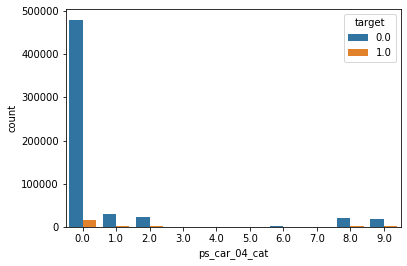

In [44]:
sns.countplot(x='ps_car_04_cat',hue='target',data=df)
plt.show()

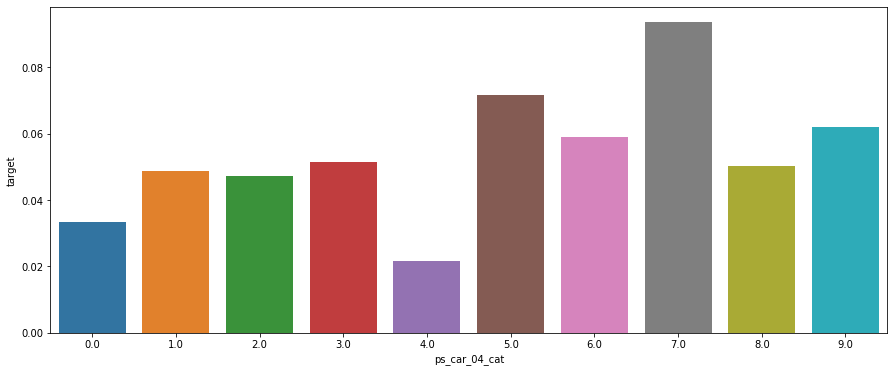

In [50]:
plt.figure(figsize=(15,6))
sns.barplot(x='ps_car_04_cat',y='target',data=df,ci=0)
plt.show()

- the above plot is showing us the proportion of the number of ones among the differnt categories in the particular column, since the target variables is comprised of 0 and 1 which in turn is the mean proprotion of the 1 among the categories.
- the proportion of target variable 1 for category 4 is 0.05(5%) which is the leat risky among others and category 7 is having the high risk factor since the proportion of one is 0.15 i,e (15%) among the rest.

### lets check for the number of categories in each variable 

In [53]:
for i in cat:
    print('NUmber of Categories: ',i,df[i].nunique())

NUmber of Categories:  ps_ind_02_cat 4
NUmber of Categories:  ps_ind_04_cat 2
NUmber of Categories:  ps_ind_05_cat 7
NUmber of Categories:  ps_car_01_cat 12
NUmber of Categories:  ps_car_02_cat 2
NUmber of Categories:  ps_car_04_cat 10
NUmber of Categories:  ps_car_06_cat 18
NUmber of Categories:  ps_car_07_cat 2
NUmber of Categories:  ps_car_08_cat 2
NUmber of Categories:  ps_car_09_cat 5
NUmber of Categories:  ps_car_10_cat 3
NUmber of Categories:  ps_car_11_cat 104


- lets use target encoder for variable ps_Car_11_cat since it has 104 categories and one hot encoding is not efficient for the same

In [11]:
from category_encoders import TargetEncoder

In [12]:
enc=TargetEncoder(cols=['ps_car_11_cat'])

In [14]:
y=df[['target']]
x=df.drop(['target','id'],1)
x=enc.fit_transform(x,y)

In [59]:
x.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2.0,2.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,1.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,5.0,4.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [61]:
x['ps_car_11_cat'].head()

0    0.038642
1    0.023936
2    0.031281
3    0.045015
4    0.026266
Name: ps_car_11_cat, dtype: float64

In [15]:
cat.remove('ps_car_11_cat')

In [65]:
cat

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat']

In [16]:
x=pd.get_dummies(x,columns=cat,drop_first=True)

In [67]:
x.shape

(595212, 100)

### Checking for outliers

In [18]:
from collections import Counter
def outliers(df):
    outliers_indices=[]
    for i in df.columns.tolist():
        #1st quartile(25%)
        q1=df[i].quantile(.25)
        #3rd quartile(75%)
        q3=df[i].quantile(.75)
        #interquantile range(IQR)
        IQR=q3-q1
        #outlier step
        outlier=1.5*IQR
        #outlier_features
        outlier_list_col=df[(df[i]<q1-outlier)|(df[i]>q3+outlier)].index
        #adding the found outlier observation into the list
        outliers_indices.extend(outlier_list_col)
    
    #counting the number of outliers found in the process
    count_indices = Counter(outliers_indices)   #this returns the dictionary of the count of outliers found in the indices     
    multiple_outliers = list( k for k, v in count_indices.items() if v > 2 )
        
    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(outliers(df))))  

The dataset contains 201640 observations with more than 2 outliers


- we can see that thers a lot of outliers which needs to be removed and now lets remove it 

In [19]:
df1=df.copy()
outlier_indices=outliers(df1)
df1 = df1.drop(outlier_indices).reset_index(drop=True)
print(df1.shape)

(393572, 57)


In [27]:
y=df1[['target']]
x=df1.drop(['target','id'],1)

### visualizing using the decision tree

In [23]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc=DTC(random_state=1,max_depth=5,max_leaf_nodes=10)
dtc.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

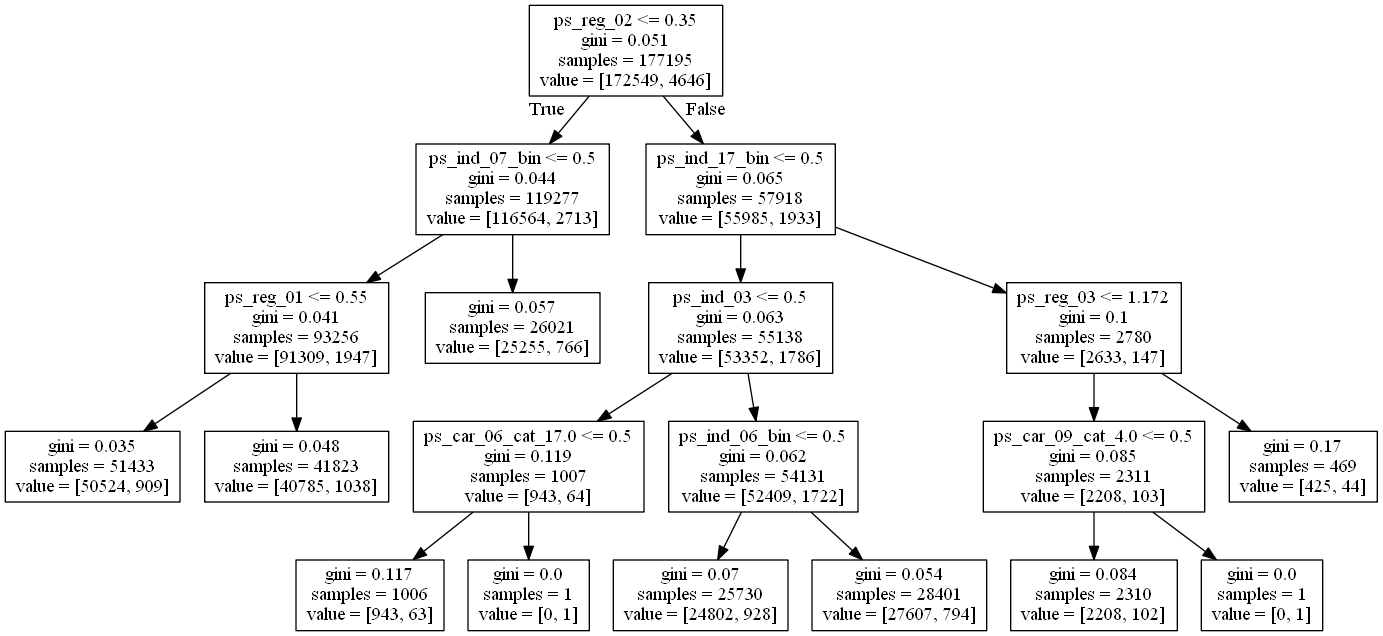

In [126]:
from IPython.display import Image 
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus 
dot_data=export_graphviz(dtc,out_file=None,feature_names=x1.columns)
graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### statistical model

In [28]:
x=x.drop(['ps_ind_06_bin','ps_ind_10_bin'],1)  # we are dropping these columns becuase it was resulting in the infinite values in the logit model

In [29]:
x_const=sm.add_constant(x)
model=sm.Logit(y,x_const).fit()
model.summary()

         Current function value: 0.084677
         Iterations: 35


H:\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               393572
Model:                          Logit   Df Residuals:                   393518
Method:                           MLE   Df Model:                           53
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                 0.03466
Time:                        18:00:11   Log-Likelihood:                -33327.
converged:                      False   LL-Null:                       -34523.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.2067      0.352    -23.304      0.000      -8.897      -7.516
ps_ind_01          0.0111      0.008      1.453      0.146      -0.004       0.026
ps_ind_02_cat      0.0008      0.020      0.039      0.969      -0.039       0.041
ps_ind_03         -0.0082      0.005     -1.643      0.100      -0.018       0.002
ps_ind_04_cat      0.0699      0.028      2.471      0.013       0.014       0.125
ps_ind_05_cat     -0.0876      0.012     -7.054      0.000      -0.112      -0.063
ps_ind_07_bin      0.1911      0.034      5.690      0.000       0.125       0.257
ps_ind_08_bin     -0.5687      0.050    -11.434      0.000      -0.666      -0.471
ps_ind_09_bin     -0.6982      0.044    -15.942      0.000      -0.784      -0.612
ps_ind_11_bin     -0.6046   2.43e+04  -2.49e-05      1.000   -4.76e+04    4.76e+04
ps_ind_12_bin     -6.3390   4.08e+04     -0.000      1.000   -8.01e+04    8.01e+04
ps_ind_13_bin     -1.6310   3.84e+04  -4.25e-05      1.000   -7.53e+04    7.53e+04
ps_ind_14        -16.7045   2.12e+04     -0.001      0.999   -4.16e+04    4.15e+04
ps_ind_15         -0.0283      0.004     -6.908      0.000      -0.036      -0.020
ps_ind_16_bin      0.0003      0.047      0.006      0.995      -0.092       0.092
ps_ind_17_bin     -0.5437      0.067     -8.142      0.000      -0.675      -0.413
ps_ind_18_bin     -0.8021      0.067    -12.046      0.000      -0.933      -0.672
ps_reg_01          0.5766      0.052     11.005      0.000       0.474       0.679
ps_reg_02         -0.0452      0.050     -0.899      0.369      -0.144       0.053
ps_reg_03          0.0567      0.051      1.108      0.268      -0.044       0.157
ps_car_01_cat      0.0106      0.006      1.911      0.056      -0.000       0.021
ps_car_02_cat      0.9289      0.064     14.500      0.000       0.803       1.054
ps_car_04_cat     -0.3214      0.037     -8.586      0.000      -0.395      -0.248
ps_car_06_cat     -0.0050      0.002     -2.133      0.033      -0.010      -0.000
ps_car_07_cat      0.6903      0.101      6.816      0.000       0.492       0.889
ps_car_08_cat      0.8397      0.050     16.788      0.000       0.742       0.938
ps_car_09_cat      0.0068      0.014      0.487      0.626      -0.021       0.034
ps_car_10_cat      1.1011      0.218      5.043      0.000       0.673       1.529
ps_car_11_cat      0.0002      0.000      0.487      0.626      -0.001       0.001
ps_car_11          0.0678      0.019      3.655      0.000       0.031       0.104
ps_car_12          1.0005      0.422      2.373      0.018       0.174       1.827
ps_car_13          0.3384      0.189      1.791      0.073      -0.032       0.709
ps_car_14         -2.0561      0.389     -5.286      0.000      -2.818      -1.294
ps_car_15          0.2502      0.033      7.528      0.000       0.185       0.315
ps_calc_01        -0.0138      0.043     -0.324      0.746      -0.097       0.070
ps_calc_02         0.0528      0.043      1.239      0.215      -0.031       0.136
ps_c

#### now lets check for the multicollinearity by checking the vif values of the variables

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=x.columns)

,vif
ps_ind_01,1.297170
ps_ind_02_cat,1.073935
ps_ind_03,1.139490
ps_ind_04_cat,1.287612
ps_ind_05_cat,1.019982
ps_ind_07_bin,1.565091
ps_ind_08_bin,1.283616
ps_ind_09_bin,1.296549
ps_ind_11_bin,9.000937
ps_ind_12_bin,214.908590


In [98]:
yprob=result.predict(x_const)

In [112]:
ypred=yprob.apply(lambda x:0 if x<0.2 else 1)

In [113]:
print(confusion_matrix(y,ypred))

[[573467     51]
 [ 21680     14]]


In [114]:
print(classification_report(y,ypred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    573518
         1.0       0.22      0.00      0.00     21694

    accuracy                           0.96    595212
   macro avg       0.59      0.50      0.49    595212
weighted avg       0.94      0.96      0.95    595212



In [110]:
fpr,tpr,thresh=roc_curve(y,yprob)
thresh[0]=thresh[0]-1
thresh

array([0.32854108, 0.32854108, 0.26547753, ..., 0.00878909, 0.00876319,
       0.00783803])

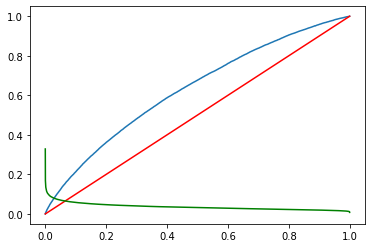

In [111]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'-r')
plt.plot(fpr,thresh,'g')
plt.show()

### model building-Machine Learning

In [81]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.33,random_state=1)

In [82]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc=RFC(n_estimators=10,random_state=1)
rfc.fit(xtrain,ytrain)
ytrain_prob=rfc.predict_proba(xtrain)[:,1]  ##taking the probability of one
ytest_prob=rfc.predict_proba(xtest)[:,1]

ytrain_pred=rfc.predict(xtrain)
ytest_pred=rfc.predict(xtest)
print('Accuracy score of train:',accuracy_score(ytrain,ytrain_pred))
print('Accuracy score of test:',accuracy_score(ytest,ytest_pred))
print('*****************************************************************')
print('AUC of train:',roc_auc_score(ytrain,ytrain_prob))
print('AUC of test:',roc_auc_score(ytest,ytest_prob))

Accuracy score of train: 0.9911407450500511
Accuracy score of test: 0.963720598717035
*****************************************************************
AUC of train: 0.9999253627755759
AUC of test: 0.5323722670251471


In [84]:
from scipy.stats import randint as sp_randint
rfc=RFC(random_state=1)
parameters={'n_estimators':sp_randint(5,100),
            'max_depth':sp_randint(2,40),
             'min_samples_split':sp_randint(2,100),
             'min_samples_leaf':sp_randint(2,100)}
randsearch=RandomizedSearchCV(rfc,param_distributions=parameters,cv=3,random_state=1)
randsearch.fit(x,y)
print(randsearch.best_params_)

{'max_depth': 39, 'min_samples_leaf': 14, 'min_samples_split': 74, 'n_estimators': 14}


In [85]:
rfc=RFC(**randsearch.best_params_,random_state=1)
rfc.fit(xtrain,ytrain)
ytrain_prob=rfc.predict_proba(xtrain)[:,1]  ##taking the probability of one
ytest_prob=rfc.predict_proba(xtest)[:,1]

ytrain_pred=rfc.predict(xtrain)
ytest_pred=rfc.predict(xtest)
print('Accuracy score of train:',accuracy_score(ytrain,ytrain_pred))
print('Accuracy score of test:',accuracy_score(ytest,ytest_pred))
print('*****************************************************************')
print('AUC of train:',roc_auc_score(ytrain,ytrain_prob))
print('AUC of test:',roc_auc_score(ytest,ytest_prob))

Accuracy score of train: 0.9634571405645048
Accuracy score of test: 0.9637460543732818
*****************************************************************
AUC of train: 0.9397228217834842
AUC of test: 0.5934689530467088


In [88]:
y_pred=rfc.predict(x)

In [89]:
print(confusion_matrix(y,y_pred))

[[573518      0]
 [ 21694      0]]
